<a href="https://colab.research.google.com/github/xuwd11/deepul/blob/master/homeworks/hw2/Homework_2_Flow_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!nvidia-smi

Sat May 16 23:21:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 727 (delta 11), reused 13 (delta 3), pack-reused 697
Receiving objects: 100% (727/727), 119.73 MiB | 33.49 MiB/s, done.
Resolving deltas: 100% (322/322), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16679 sha256=a264a3a21b44ae2dd8b6c6d7b87fdfd10007f9e1e3a6764dcb453f5d6fffc498
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ch4v8fw/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [ ]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


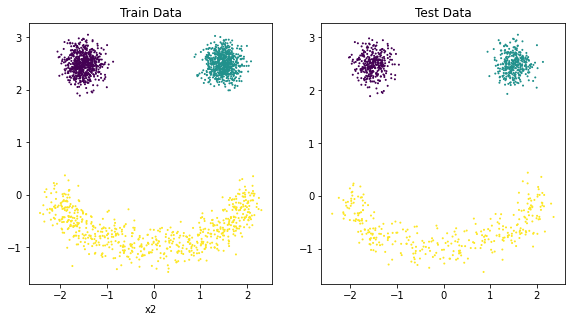

Dataset 2


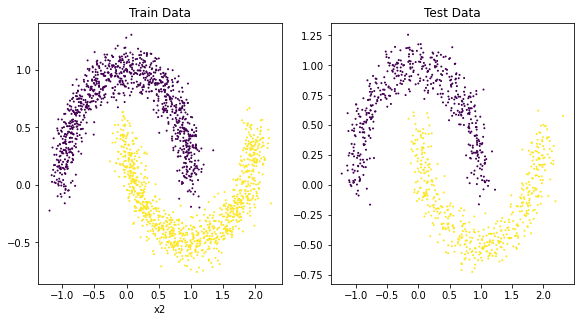

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow [15pt]

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d \log p(z_i) + \log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space. 




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm_notebook

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_epoch(model, train_loader, optimizer, grad_clip=None):
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.to(device)
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train(model, train_loader, test_loader, train_args, print_every=None):
    t0 = time.time()
    n_epochs, lr = train_args["n_epochs"], train_args["lr"]
    grad_clip = train_args.get("grad_clip", None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]

    for epoch in tqdm_notebook(range(n_epochs), desc='Epoch', leave=False):
        train_losses.extend(train_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer, grad_clip=grad_clip
        ))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        if print_every and (epoch==n_epochs - 1 or epoch % print_every == 0):
            t = (time.time() - t0) / 60
            print(f"Epoch {epoch}, test loss {test_loss:.4f}, time elapsed {t:.3f} min")
    return train_losses, test_losses

def uniform_init(low, high, device=device):
    return torch.distributions.Uniform(
        torch.tensor(low).to(device), torch.tensor(high).to(device)
    )

def normal_init(loc, scale, device=device):
    return torch.distributions.Normal(
        torch.tensor(loc).to(device), torch.tensor(scale).to(device)
    )

In [ ]:
# For debugging purpose

# train_data, train_labels, test_data, test_labels = q1_sample_data_1()
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MixtureCDFFlow(nn.Module):
    def __init__(self, n_components=5, plot_bounds=(-3, 3)):
        super().__init__()
        self.base_dist = uniform_init(0.0, 1.0)
        
        self.loc = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_scale = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.mixture_dist_init = torch.distributions.Normal
        self.n_components = n_components
        self.plot_bounds = plot_bounds
    
    def flow(self, x):
        # z = cdf of x
        weights = F.softmax(self.weight_logits, dim=0).unsqueeze(0)
        z = (self.mixture_dist_init(self.loc, self.log_scale.exp())\
             .cdf(x.unsqueeze(1)) * weights).sum(dim=1)

        # log_det = log dz/dx = log pdf(x)
        log_det = (self.mixture_dist_init(self.loc, self.log_scale.exp())\
                   .log_prob(x.unsqueeze(1)).exp() * weights).sum(dim=1).log()
        
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return self.base_dist.log_prob(z) + log_det
    
    def loss(self, x):
        return -self.log_prob(x).mean()

class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.extend([
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
            ])
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class AutoregressiveFlow(nn.Module):
    """
    Modeling a 2D distribution
    """
    def __init__(
        self, dim1_n_components=5, dim2_n_components=5, mlp_n_hidden=3, mlp_hidden_size=64
    ):
        super().__init__()
        self.dim1_flow = MixtureCDFFlow(dim1_n_components)
        self.mlp = MLP(1, mlp_n_hidden, mlp_hidden_size, dim2_n_components * 3)
        self.dim2_n_components = dim2_n_components
        self.base_dist = uniform_init(0.0, 1.0)
        self.mixture_dist_init = torch.distributions.Normal
    
    def flow(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        # dim1
        z1, log_det1 = self.dim1_flow.flow(x1.squeeze())

        # dim2
        loc, log_scale, weight_logits = torch.chunk(self.mlp(x1), 3, dim=1)
        weights = F.softmax(weight_logits, dim=1)
        z2 = (self.mixture_dist_init(loc, log_scale.exp())\
              .cdf(x2) * weights).sum(dim=1)
        log_det2 = (self.mixture_dist_init(loc, log_scale.exp())\
                    .log_prob(x2).exp() * weights).sum(dim=1).log()
        z = torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1)
        log_det = torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1)
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return (self.base_dist.log_prob(z) + log_det).sum(dim=1)

    def loss(self, x):
        return -self.log_prob(x).mean()

# For debugging purpose
# model = AutoregressiveFlow().to(device)
# for x in train_loader:
#     x = x.to(device).float()
#     print(x.shape)
#     print(model.loss(x))
#     break

In [ ]:
def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets, or
                for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """
    
    """ YOUR CODE HERE """
    # create data loaders
    train_data, test_data = train_data.astype(np.float32), test_data.astype(np.float32)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
    
    # model
    model = AutoregressiveFlow().to(device)

    # train
    train_losses, test_losses = train(
        model, train_loader, test_loader, dict(n_epochs=100, lr=5e-3), print_every=None
    )

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(device)
    with torch.no_grad():
        densities = np.exp(model.log_prob(mesh_xs).cpu().numpy())

        # latents
        latents = model.flow(torch.FloatTensor(train_data).to(device))[0].cpu().numpy()

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Final Test Loss: 1.3440


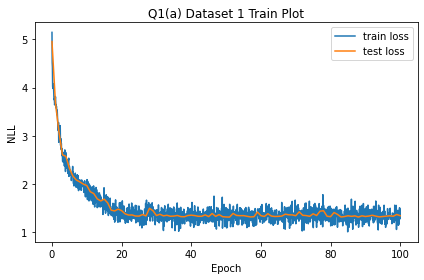

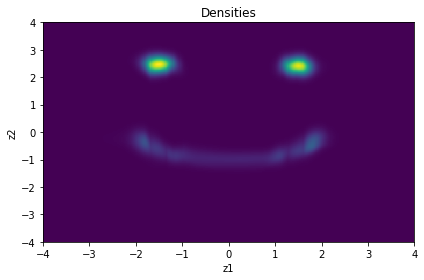

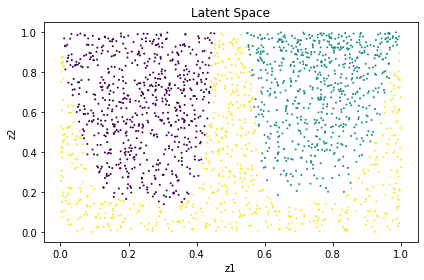

CPU times: user 13.9 s, sys: 592 ms, total: 14.5 s
Wall time: 14.3 s


In [ ]:
%%time

q1_save_results(1, 'a', q1_a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Final Test Loss: 1.0389


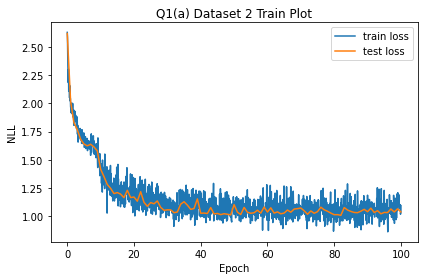

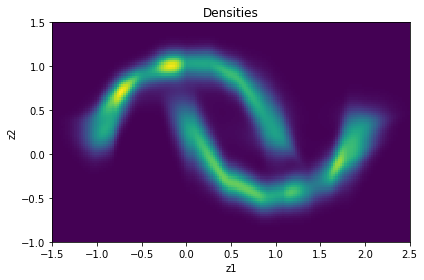

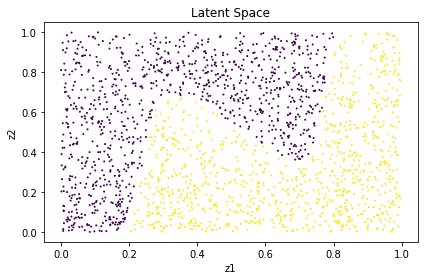

CPU times: user 11.3 s, sys: 493 ms, total: 11.8 s
Wall time: 11.6 s


In [ ]:
%%time

q1_save_results(2, 'a', q1_a)

## Part (b) RealNVP [15pt]
In this part, we want to train a flow with the following structure: 
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$, 
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other, and $z \sim N(0, I)$. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have 

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters.


**Train a RealNVP model and provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# For debugging purpose

# train_data, train_labels, test_data, test_labels = q1_sample_data_1()
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
class AffineTransform(nn.Module):
    def __init__(self, mask_type, n_hidden=2, hidden_size=256):
        super().__init__()
        self.register_buffer("mask", self.build_mask(mask_type))
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.mlp = MLP(input_size=2, n_hidden=n_hidden, hidden_size=hidden_size, output_size=2)
    
    def build_mask(self, mask_type):
        assert mask_type in {"left", "right"}
        if mask_type == "left":
            mask = torch.FloatTensor([1.0, 0.0])
        elif mask_type == "right":
            mask = torch.FloatTensor([0.0, 1.0])
        return mask

    def forward(self, x, reverse=False):
        mask = self.mask.unsqueeze(0)
        x_ = x * mask
        log_s, t = self.mlp(x_).split(1, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)
        if reverse:
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

class RealNVP(nn.Module):
    def __init__(self, transforms):
        super().__init__()
        self.prior = normal_init(0.0, 1.0)
        self.transforms = nn.ModuleList(transforms)

    def flow(self, x):
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op(z)
            log_det += delta_log_det
        return z, log_det
    
    def inverse_flow(self, z):
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        return z

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return self.prior.log_prob(z).sum(dim = 1) + log_det.sum(dim=1)
    
    def sample(self, n):
        z = self.prior.sample([n, 2])
        return self.invert_flow(z)

    def loss(self, x):
        return -self.log_prob(x).mean()


# For debugging purpose

# # model = AffineTransform("left").to(device)
# model = RealNVP([
#     AffineTransform("left", n_hidden=2, hidden_size=64),
#     AffineTransform("right", n_hidden=2, hidden_size=64),
#     AffineTransform("left", n_hidden=2, hidden_size=64),
#     AffineTransform("right", n_hidden=2, hidden_size=64),
#     AffineTransform("left", n_hidden=2, hidden_size=64),
#     AffineTransform("right", n_hidden=2, hidden_size=64),
# ]).to(device)

# for x in train_loader:
#     x = x.to(device).float()
#     print(x.shape)
#     print(model.loss(x))
#     break

In [ ]:
def q1_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets, or
                for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in R^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """
    
    """ YOUR CODE HERE """
    # create data loaders
    train_data, test_data = train_data.astype(np.float32), test_data.astype(np.float32)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

    # model
    model = RealNVP([
        AffineTransform("left", n_hidden=2, hidden_size=64),
        AffineTransform("right", n_hidden=2, hidden_size=64),
        AffineTransform("left", n_hidden=2, hidden_size=64),
        AffineTransform("right", n_hidden=2, hidden_size=64),
        AffineTransform("left", n_hidden=2, hidden_size=64),
        AffineTransform("right", n_hidden=2, hidden_size=64),
    ]).to(device)

    # train
    train_losses, test_losses = train(
        model, train_loader, test_loader, dict(n_epochs=250, lr=5e-3), print_every=None
    )

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(device)
    with torch.no_grad():
        densities = np.exp(model.log_prob(mesh_xs).cpu().numpy())

        # latents
        latents = model.flow(torch.FloatTensor(train_data).to(device))[0].cpu().numpy()

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Final Test Loss: 1.4740


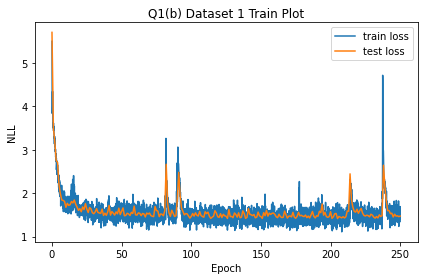

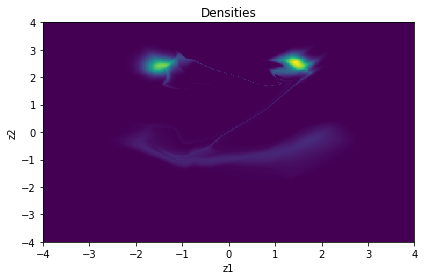

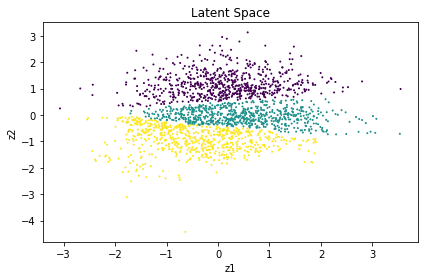

CPU times: user 56.9 s, sys: 804 ms, total: 57.7 s
Wall time: 57.9 s


In [ ]:
%%time

q1_save_results(1, 'b', q1_b)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Final Test Loss: 1.0716


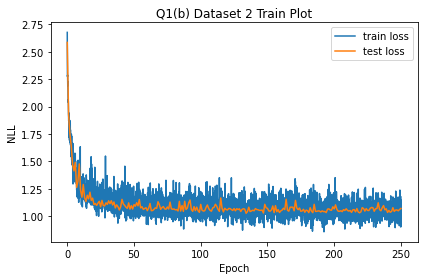

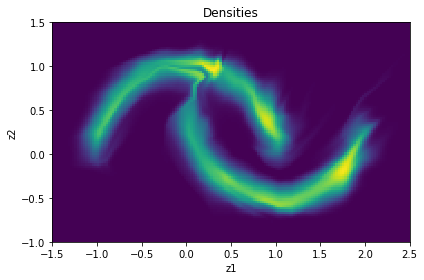

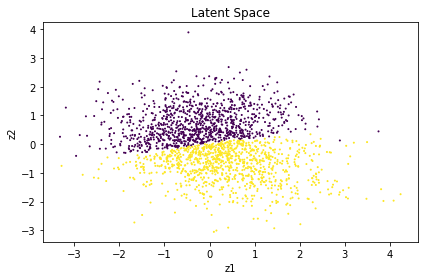

CPU times: user 53 s, sys: 707 ms, total: 53.7 s
Wall time: 53.9 s


In [ ]:
%%time

q1_save_results(2, 'b', q1_b)

# Question 2: Autoregressive Flows for Images [20pt]
We can scale up the autoregressive flows from 1(a) to high-dimensional image data. In this question, we will focus on the black-and-white shapes dataset from Homework 1.

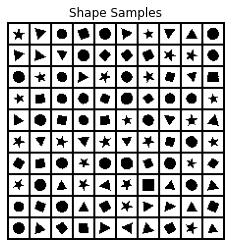

In [ ]:
visualize_q2_data()

Adapt your PixelCNN implementation from Homework 1 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 1 3(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# For debugging purpose

# import numpy as np

# data_dir = get_data_dir(2)
# train_data, test_data = load_pickled_data(join(data_dir, 'shapes.pkl'))
# train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32) / 2.0
# test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32) / 2.0
# img_shape = (20, 20)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MaskConv2d(nn.Conv2d):
    def __init__(
        self, mask_type, *args, conditional_size=None, color_conditioning=False, **kwargs
    ):
        assert mask_type == "A" or mask_type == "B"
        super().__init__(*args, **kwargs)
        self.conditional_size = conditional_size
        self.color_conditioning = color_conditioning
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)
        if self.conditional_size is not None:
            if len(self.conditional_size) == 1:
                self.cond_op = nn.Linear(conditional_size[0], self.out_channels)
            else:
                self.cond_op = nn.Conv2d(
                    conditional_size[0], self.out_channels, kernel_size=3, padding=1
                )

    def create_mask(self, mask_type):
        k = self.kernel_size
        self.mask[:, :, :k[0] // 2] = 1
        self.mask[:, :, k[0] // 2, :k[1] // 2] = 1
        if self.color_conditioning:
            assert self.in_channels % 3 == 0 and self.out_channels % 3 == 0
            one_third_in, one_third_out = self.in_channels // 3, self.out_channels // 3
            if mask_type == "B":
                self.mask[:one_third_out, :one_third_in, k[0] // 2, k[1] // 2] = 1
                self.mask[one_third_out: 2 * one_third_out, :2 * one_third_in, k[0] // 2, k[1]//2] = 1
                self.mask[2 * one_third_out:, :, k[0] // 2, k[1] // 2] = 1
            else:                
                self.mask[one_third_out: 2 * one_third_out, :one_third_in, k[0] // 2, k[1]//2] = 1
                self.mask[2 * one_third_out:, :2 * one_third_in, k[0] // 2, k[1] // 2] = 1
        else:
            if mask_type == "B":
                self.mask[:, :, k[0] // 2, k[1] // 2] = 1

    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = F.conv2d(
            input=x, 
            weight=self.mask * self.weight, 
            bias=self.bias, 
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups,
        )
        if self.conditional_size is not None:
            if len(self.conditional_size) == 1:
                out = out + self.cond_op(cond).view(batch_size, -1, 1, 1)
            else:
                out = out + self.cond_op(cond)
        return out

class ResBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, **kwargs):
        super().__init__()
        self.block = nn.ModuleList([
            nn.ReLU(),
            MaskConv2d("B", in_channels, in_channels // 2, 1, **kwargs),
            nn.ReLU(),
            MaskConv2d(
                "B", in_channels // 2, in_channels // 2, kernel_size, padding=kernel_size // 2, **kwargs
            ),
            nn.ReLU(),
            MaskConv2d("B", in_channels // 2, in_channels, 1, **kwargs),
        ])

    def forward(self, x, cond=None):
        out = x
        for layer in self.block:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out + x

class LayerNorm(nn.LayerNorm):
    def __init__(self, color_conditioning, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.color_conditioning = color_conditioning
    
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        if self.color_conditioning:
            x_shape = x.shape
            x = x.view(*(x_shape[:-1] + (3, -1)))
        x = super().forward(x)
        if self.color_conditioning:
            x = x.view(*x_shape)
        return x.permute(0, 3, 1, 2).contiguous()

class AutoregressiveFlowPixelCNN(nn.Module):
    def __init__(
        self, input_shape, n_filters=64, kernel_size=7, n_layers=5, n_components=10,
        conditional_size=None, use_resblock=False, color_conditioning=False,
    ):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0]

        if conditional_size is not None or color_conditioning:
            raise NotImplementedError

        kwargs = dict(
            conditional_size=conditional_size, color_conditioning=color_conditioning
        )
        
        if use_resblock:
            block_init = lambda: ResBlock(n_filters, kernel_size, **kwargs)
        else:
            block_init = lambda: MaskConv2d(
                "B", n_filters, n_filters, kernel_size=kernel_size, padding=kernel_size //2 , **kwargs
            )

        model = nn.ModuleList([
            MaskConv2d(
                "A", n_channels, n_filters, kernel_size=kernel_size, padding=kernel_size //2 , **kwargs
            )
        ])

        for _ in range(n_layers):
            if color_conditioning:
                model.append(LayerNorm(color_conditioning, n_filters // 3))
            else:
                model.append(LayerNorm(color_conditioning, n_filters))
            model.extend([nn.ReLU(), block_init()])
        model.extend([nn.ReLU(), MaskConv2d("B", n_filters, n_filters, 1, **kwargs)])
        model.extend([nn.ReLU(), MaskConv2d("B", n_filters, n_components * 3 * n_channels, 1, **kwargs)])
        
        if conditional_size:
            if len(conditional_size) == 1:
                self.cond_op = lambda x: x
            else:
                self.cond_op = nn.Sequential(
                    nn.Conv2d(1, 64, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, padding=1),
                    nn.ReLU(),
                )

        self.net = model
        self.input_shape = input_shape
        self.n_channels = n_channels
        self.color_conditioning = color_conditioning
        self.conditional_size = conditional_size
        self.n_components = n_components

    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = x.float()
        if self.conditional_size:
            cond = self.cond_op(cond)
        for layer in self.net:
            if isinstance(layer, MaskConv2d) or isinstance(layer, ResBlock):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        
        if self.color_conditioning:
            return out.view(
                batch_size, self.n_channels, self.n_colors, *self.input_shape[1:]
            ).permute(0, 2, 1, 3, 4)
        else:
            return out.view(batch_size, 3 * self.n_components, *self.input_shape)

    def loss(self, x, cond=None):
        loc, log_scale, weight_logits = torch.chunk(self(x), 3, dim=1)
        weights = F.softmax(weight_logits, dim=1)
        dist = torch.distributions.Normal(loc, log_scale.exp())
        log_prob = (dist.log_prob(x.unsqueeze(1)).exp() * weights).sum(dim=1).log()
        return -log_prob.mean()

    def sample(self, n, cond=None, device=device):
        samples = torch.zeros(n, *self.input_shape).to(device)
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        loc, log_scale, weight_logits = torch.chunk(self(samples), 3, dim=1)
                        weights = F.softmax(weight_logits[:, :, k, r, c], dim=1)
                        components = torch.multinomial(weights, 1).squeeze(-1)
                        loc = loc[torch.arange(n), components, k, r, c]
                        log_scale = log_scale[torch.arange(n), components, k, r, c]
                        samples[:, k, r, c] = torch.normal(loc, log_scale.exp())
        return samples.permute(0, 2, 3, 1).cpu().numpy()

# For debugging purpose

# model = AutoregressiveFlowPixelCNN((1, 20, 20), n_layers=5, n_components=10).to(device)

# for x in train_loader:
#     print(x.shape)
#     print(model.loss(x.to(device)))
#     s = model.sample(2)
#     break

In [ ]:
def train_epoch_q2(model, train_loader, optimizer, grad_clip=None):
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.to(device)
        x += torch.distributions.Uniform(0.0, 0.5).sample(x.shape).to(device)
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses

def train_q2(model, train_loader, test_loader, train_args, print_every=None):
    t0 = time.time()
    n_epochs, lr = train_args["n_epochs"], train_args["lr"]
    grad_clip = train_args.get("grad_clip", None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]

    for epoch in tqdm_notebook(range(n_epochs), desc='Epoch', leave=False):
        train_losses.extend(train_epoch_q2(
            model=model, train_loader=train_loader, optimizer=optimizer, grad_clip=grad_clip
        ))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        if print_every and (epoch==n_epochs - 1 or epoch % print_every == 0):
            t = (time.time() - t0) / 60
            print(f"Epoch {epoch}, test loss {test_loss:.4f}, time elapsed {t:.3f} min")
    return train_losses, test_losses

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    H = W = 20
    Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
        and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
    """
    
    """ YOUR CODE HERE """
    train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32) / 2.0
    test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32) / 2.0
    test_data += np.random.uniform(high=0.5, size=test_data.shape)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
    _, __, H, W = train_data.shape
    model = AutoregressiveFlowPixelCNN((1, H, W), n_layers=5, n_components=10).to(device)
    train_losses, test_losses = train_q2(
        model, train_loader, test_loader, dict(n_epochs=20, lr=1e-3), print_every=None
    )
    samples = model.sample(100)
    return train_losses + np.log(2), test_losses + np.log(2), samples

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Final Test Loss: 0.0908


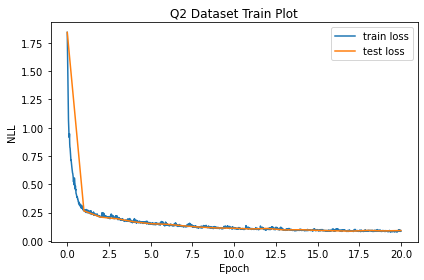

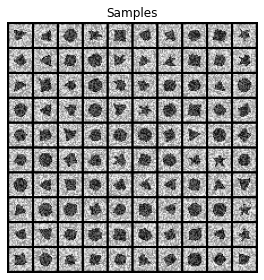

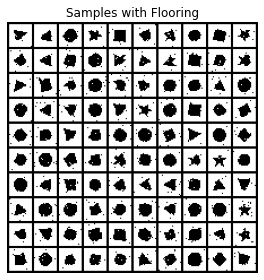

CPU times: user 45.8 s, sys: 20.5 s, total: 1min 6s
Wall time: 1min 6s


In [ ]:
%%time

q2_save_results(q2)

# Question 3: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



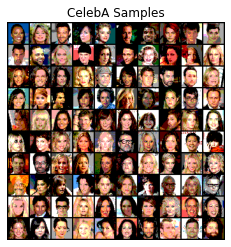

In [ ]:
visualize_q3_data()

## Part (a): RealNVP [40pt]

Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 128, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=n_filters, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=n_filters
  relu()
  conv2d(in_channels=n_filters, out_channels=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.55 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# For debugging purpose

# train_data, test_data = get_q3_data()
# train_data = np.transpose(train_data, (0, 3, 1, 2))
# test_data = np.transpose(test_data, (0, 3, 1, 2))
# train_loader = torch.utils.data.DataLoader(
#     train_data, batch_size=64, shuffle=True, pin_memory=False
# )
# test_loader = torch.utils.data.DataLoader(
#     test_data, batch_size=64, shuffle=False, pin_memory=False
# )

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm, tqdm_notebook

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def normal_init(loc, scale, device=device):
    return torch.distributions.Normal(
        torch.tensor(loc).to(device), torch.tensor(scale).to(device)
    )

class WeightNormConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.conv = nn.utils.weight_norm(nn.Conv2d(*args, **kwargs))
    
    def forward(self, x):
        return self.conv(x)

class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=(0, 2, 3), keepdim=True)
                self.log_scale.data = -torch.log(
                    torch.std(
                        x.permute(1, 0, 2, 3).reshape(self.n_channels, -1), dim=1
                    ).reshape(1, self.n_channels, 1, 1)
                )
                self.initialized = True
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale

class WeightNormResBlock(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(n_filters, n_filters, kernel_size=1), 
            WeightNormConv2d(n_filters, n_filters, kernel_size=3, padding=1),
            WeightNormConv2d(n_filters, n_filters, kernel_size=1),  
        )

    def forward(self, x):
        return x + self.block(x)

class SimpleResNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_filters, n_blocks):
        super().__init__()
        layers = [
            WeightNormConv2d(in_channels, n_filters, kernel_size=3, padding=1),
            nn.ReLU(),
        ]
        for _ in range(n_blocks):
            layers.append(WeightNormResBlock(n_filters))
            layers.append(nn.ReLU())
        layers.append(WeightNormConv2d(n_filters, out_channels, kernel_size=3, padding=1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

class AffineCheckerboardTransform(nn.Module):
    def __init__(self, input_shape, mask_type=1.0):
        super().__init__()
        assert mask_type in (1.0, 0.0)
        self.input_shape = input_shape
        self.create_mask(mask_type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResNet(input_shape[0], input_shape[0] * 2, 64, 4)
    
    def create_mask(self, mask_type):
        # if mask_type == 1.0, the top left corner will be 1.0
        # if mask_type == 0.0, the top left corner will be 0.0
        mask = np.arange(self.input_shape[-2]).reshape(-1, 1) + np.arange(self.input_shape[-1])
        mask = np.mod(mask + mask_type, 2)
        mask = mask.reshape(1, 1, self.input_shape[-2], self.input_shape[-1])
        self.register_buffer("mask", torch.tensor(mask.astype("float32")))

    def forward(self, x, reverse=False):
        x_ = x * self.mask
        log_s, t = self.resnet(x_).chunk(2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - self.mask)
        log_s = log_s * (1.0 - self.mask)

        if reverse:
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

class AffineChannelTransform(nn.Module):
    def __init__(self, n_channels, mask_type=1.0):
        super().__init__()
        assert n_channels % 2 == 0
        assert mask_type in (1.0, 0.0)
        self.mask_type = mask_type
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResNet(n_channels // 2, n_channels, 64, 4)

    def forward(self, x, reverse=False):
        if self.mask_type == 1.0:
            on, off = x.chunk(2, dim=1)
        else:
            off, on = x.chunk(2, dim=1)
        log_s, t = self.resnet(off).chunk(2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift

        if reverse:
            on = (on - t) * torch.exp(-log_s)
        else:
            on = on * torch.exp(log_s) + t
        
        if self.mask_type == 1.0:
            return torch.cat([on, off], dim=1), \
            torch.cat([log_s, torch.zeros_like(log_s)], dim=1)
        else:
            return torch.cat([off, on], dim=1), \
            torch.cat([torch.zeros_like(log_s), log_s], dim=1)

class RealNVP(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.prior = normal_init(0.0, 1.0)
        self.checker_transforms1 = nn.ModuleList([
            AffineCheckerboardTransform(input_shape, 1.0),
            ActNorm(input_shape[0]),
            AffineCheckerboardTransform(input_shape, 0.0),
            ActNorm(input_shape[0]),
            AffineCheckerboardTransform(input_shape, 1.0),
            ActNorm(input_shape[0]),
            AffineCheckerboardTransform(input_shape, 0.0),
        ])
        self.channel_transforms = nn.ModuleList([
            AffineChannelTransform(input_shape[0] * 4, 1.0),
            ActNorm(input_shape[0] * 4),
            AffineChannelTransform(input_shape[0] * 4, 0.0),
            ActNorm(input_shape[0] * 4),
            AffineChannelTransform(input_shape[0] * 4, 1.0),
        ])
        self.checker_transforms2 = nn.ModuleList([
            AffineCheckerboardTransform(input_shape, 1.0),
            ActNorm(input_shape[0]),
            AffineCheckerboardTransform(input_shape, 0.0),
            ActNorm(input_shape[0]),
            AffineCheckerboardTransform(input_shape, 1.0),
        ])

    def squeeze(self, x):
        # (C, H, W) -> (4C, H/2, W/2)
        B, C, H, W = x.shape
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    def unsqueeze(self, x):
        # (4C, H/2, W/2) -> (C, H, W)
        B, C, H, W = x.shape
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x

    def f(self, x):
        # x -> z, log_det
        z, log_det = x, torch.zeros_like(x)
        for op in self.checker_transforms1:
            z, delta_log_det = op(z)
            log_det += delta_log_det
        z, log_det = self.squeeze(z), self.squeeze(log_det)
        for op in self.channel_transforms:
            z, delta_log_det = op(z)
            log_det += delta_log_det
        z, log_det = self.unsqueeze(z), self.unsqueeze(log_det)
        for op in self.checker_transforms2:
            z, delta_log_det = op(z)
            log_det += delta_log_det
        return z, log_det
    
    def g(self, z):
        # z -> x
        x = z
        for op in reversed(self.checker_transforms2):
            x, _ = op(x, reverse=True)
        x = self.squeeze(x)
        for op in reversed(self.channel_transforms):
            x, _ = op(x, reverse=True)
        x = self.unsqueeze(x)
        for op in reversed(self.checker_transforms1):
            x, _ = op(x, reverse=True)
        return x

    def log_prob(self, x):
        z, log_det = self.f(x)
        return log_det.sum(dim=(1, 2, 3)) + self.prior.log_prob(z).sum(dim=(1, 2, 3))

    def sample(self, n):
        z = self.prior.sample((n, ) + tuple(self.input_shape))
        return self.g(z)

# For debugging purpose
# input_shape = (3, 32, 32)
# model = nn.Sequential(
#     SimpleResNet(3, 3, 8, 4), 
#     ActNorm(3),
# ).to(device)
# input_shape = (3, 32, 32)
# model = nn.Sequential(
#     AffineCheckerboardTransform(input_shape),
# ).to(device)
# input_shape = (3, 32, 32)
# model = nn.Sequential(
#     SimpleResNet(3, 12, 1, 1),
#     AffineChannelTransform(12),
# ).to(device)
# input_shape = (3, 32, 32)
# model = RealNVP(input_shape).to(device)

# for x in train_loader:
#     x = x.float().to(device)
#     print(x.shape)
#     print(model.log_prob(x))
#     break

# s = model.sample(5)
# print(s.shape)

In [ ]:
class Solver:
    def __init__(self, lr=5e-4, n_epochs=0):
        self.train_loader, self.test_loader = self.create_loaders()
        self.log_interval = 100
        self.n_epochs = n_epochs
        self.lr = lr
        self.n_batches_per_epoch = len(self.train_loader)

    def create_loaders(self):
        train_data, test_data = get_q3_data()
        train_data = np.transpose(train_data, (0, 3, 1, 2))
        test_data = np.transpose(test_data, (0, 3, 1, 2))
        self.input_shape = train_data.shape[1:]
        train_loader = torch.utils.data.DataLoader(
            train_data, batch_size=64, shuffle=False, pin_memory=False
        )
        test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=64, shuffle=False, pin_memory=False
        )
        return train_loader, test_loader

    def build(self):
        self.flow = RealNVP(self.input_shape).to(device)
        self.optimizer = optim.Adam(self.flow.parameters(), lr=self.lr)

    def save_model(self, filename):
        torch.save(self.flow, filename)

    def load_model(self, filename):
        self.flow = torch.load(filename, map_location=device)
    
    def preprocess(self, x, reverse=False, dequantize=True):
        if reverse:
            x = 1.0 / (1.0 + torch.exp(-x))
            x -= 0.05
            x /= 0.9
            return x
        else:
            if dequantize:
                x += torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(device)
            x /= 4.0

            x *= 0.9
            x += 0.05
            logit = torch.log(x) - torch.log(1.0 - x)
            log_det = F.softplus(logit) + F.softplus(-logit) + torch.log(torch.tensor(0.9 / 4.0))
            return logit, log_det.sum(dim=(1, 2, 3))

    def eval_loss(self, data_loader):
        t0 = time.time()
        losses = []
        n_dim = np.prod(data_loader.dataset.shape[-3:])
        self.flow.eval()
        with torch.no_grad():
            for x in data_loader:
                x = x.to(device).float()
                logit_x, log_det = self.preprocess(x)
                log_prob = self.flow.log_prob(logit_x) + log_det
                losses.append((-log_prob.mean() / n_dim).item())
            avg_loss = np.mean(losses)
        t = time.time() - t0
        s = f"Calc done | It took {t:.2f} s | Loss: {avg_loss:.4f}"
        tqdm.write(s)
        return avg_loss

    def train(self, model_name="realnvp"):
        t0 = time.time()
        train_losses = []
        test_losses = []
        n_dim = np.prod(self.train_loader.dataset.shape[-3:])
        for epoch in range(1, self.n_epochs + 1):
            self.flow.train()
            batch_losses = []
            for x in tqdm_notebook(self.train_loader, desc="Batch", leave=False):
                x = x.to(device).float()
                logit_x, log_det = self.preprocess(x)
                log_prob = self.flow.log_prob(logit_x)
                log_prob += log_det
                batch_loss = -log_prob.mean() / n_dim
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                batch_losses.append(batch_loss.item())
            epoch_loss = np.mean(batch_losses)
            if epoch % 10 == 0:
                self.save_model(f"{model_name}_{epoch}.model")
            train_losses.append(epoch_loss)
            test_losses.append(self.eval_loss(self.test_loader))
            np.save(f"{model_name}_train_losses.npy", np.array(train_losses))
            np.save(f"{model_name}_test_losses.npy", np.array(test_losses))
            t = (time.time() - t0) / 60
            tqdm.write("Epoch {}, train loss {:.4f}, test loss {:.4f}, time elapsed {:.3f} min".format(
                epoch, train_losses[-1], test_losses[-1], t
            ))
        self.save_model(f"{model_name}_final.model")
        return train_losses, test_losses

    def sample(self, n):
        with torch.no_grad():
            raw_samples = self.flow.sample(n).cpu()
            samples = self.preprocess(raw_samples, reverse=True)
            return samples.cpu().numpy()

    def interpolate(self):
        self.flow.eval()
        chosen = [5, 13, 16, 19, 22]
        indices = []
        for i in chosen:
            indices.append(i * 2)
            indices.append(i * 2 + 1)
        with torch.no_grad():
            x = next(iter(self.test_loader))[indices].to(device)
            assert x.shape[0] % 2 == 0
            logit_x, _ = self.preprocess(x.float(), dequantize=False)
            z, _ = self.flow.f(logit_x)
            latents = []
            for i in range(0, x.shape[0], 2):
                a = z[i: i + 1]
                b = z[i + 1: i + 2]
                diff = (b - a) / 5.0
                latents.append(a)
                for j in range(1, 5):
                    latents.append(a + diff * float(j))
                latents.append(b)
            latents = torch.cat(latents, dim=0)
            logit_y = self.flow.g(latents)
            y = self.preprocess(logit_y, reverse=True)
            return y.cpu().numpy()

In [ ]:
solver = Solver(n_epochs=50)
solver.build()
solver.train(model_name="realnvp")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Calc done | It took 10.01 s | Loss: 0.6673
Epoch 1, train loss 0.7493, test loss 0.6673, time elapsed 1.829 min


Calc done | It took 10.00 s | Loss: 0.6253
Epoch 2, train loss 0.6447, test loss 0.6253, time elapsed 3.643 min


Calc done | It took 10.01 s | Loss: 0.6056
Epoch 3, train loss 0.6165, test loss 0.6056, time elapsed 5.464 min


Calc done | It took 10.00 s | Loss: 0.5926
Epoch 4, train loss 0.6005, test loss 0.5926, time elapsed 7.285 min


Calc done | It took 10.00 s | Loss: 0.5848
Epoch 5, train loss 0.5889, test loss 0.5848, time elapsed 9.104 min


Calc done | It took 10.00 s | Loss: 0.5759
Epoch 6, train loss 0.5803, test loss 0.5759, time elapsed 10.922 min


Calc done | It took 10.00 s | Loss: 0.5689
Epoch 7, train loss 0.5732, test loss 0.5689, time elapsed 12.741 min


Calc done | It took 10.00 s | Loss: 0.5631
Epoch 8, train loss 0.5672, test loss 0.5631, time elapsed 14.559 min


Calc done | It took 10.00 s | Loss: 0.5566
Epoch 9, train loss 0.5620, test loss 0.5566, time elapsed 16.377 min


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RealNVP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AffineCheckerboardTransform. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SimpleResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type WeightNormConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be chec

Calc done | It took 10.00 s | Loss: 0.5539
Epoch 10, train loss 0.5570, test loss 0.5539, time elapsed 18.197 min


Calc done | It took 10.00 s | Loss: 0.5482
Epoch 11, train loss 0.5529, test loss 0.5482, time elapsed 20.016 min


Calc done | It took 9.99 s | Loss: 0.5461
Epoch 12, train loss 0.5490, test loss 0.5461, time elapsed 21.834 min


Calc done | It took 10.00 s | Loss: 0.5412
Epoch 13, train loss 0.5452, test loss 0.5412, time elapsed 23.652 min


Calc done | It took 9.99 s | Loss: 0.5400
Epoch 14, train loss 0.5416, test loss 0.5400, time elapsed 25.470 min


Calc done | It took 10.00 s | Loss: 0.5350
Epoch 15, train loss 0.5384, test loss 0.5350, time elapsed 27.290 min


Calc done | It took 9.99 s | Loss: 0.5327
Epoch 16, train loss 0.5355, test loss 0.5327, time elapsed 29.107 min


Calc done | It took 9.99 s | Loss: 0.5294
Epoch 17, train loss 0.5327, test loss 0.5294, time elapsed 30.925 min


Calc done | It took 9.99 s | Loss: 0.5275
Epoch 18, train loss 0.5301, test loss 0.5275, time elapsed 32.744 min


Calc done | It took 10.00 s | Loss: 0.5238
Epoch 19, train loss 0.5273, test loss 0.5238, time elapsed 34.559 min


Calc done | It took 9.99 s | Loss: 0.5227
Epoch 20, train loss 0.5252, test loss 0.5227, time elapsed 36.376 min


Calc done | It took 9.99 s | Loss: 0.5220
Epoch 21, train loss 0.5232, test loss 0.5220, time elapsed 38.193 min


Calc done | It took 9.99 s | Loss: 0.5194
Epoch 22, train loss 0.5208, test loss 0.5194, time elapsed 40.009 min


Calc done | It took 10.00 s | Loss: 0.5172
Epoch 23, train loss 0.5192, test loss 0.5172, time elapsed 41.827 min


Calc done | It took 9.99 s | Loss: 0.5140
Epoch 24, train loss 0.5170, test loss 0.5140, time elapsed 43.645 min


Calc done | It took 9.99 s | Loss: 0.5128
Epoch 25, train loss 0.5153, test loss 0.5128, time elapsed 45.462 min


Calc done | It took 10.00 s | Loss: 0.5129
Epoch 26, train loss 0.5137, test loss 0.5129, time elapsed 47.281 min


Calc done | It took 9.99 s | Loss: 0.5167
Epoch 27, train loss 0.5121, test loss 0.5167, time elapsed 49.099 min


Calc done | It took 9.99 s | Loss: 0.5073
Epoch 28, train loss 0.5104, test loss 0.5073, time elapsed 50.916 min


Calc done | It took 9.99 s | Loss: 0.5062
Epoch 29, train loss 0.5089, test loss 0.5062, time elapsed 52.734 min


Calc done | It took 9.99 s | Loss: 0.5043
Epoch 30, train loss 0.5076, test loss 0.5043, time elapsed 54.550 min


Calc done | It took 10.00 s | Loss: 0.5036
Epoch 31, train loss 0.5065, test loss 0.5036, time elapsed 56.369 min


Calc done | It took 9.99 s | Loss: 0.5033
Epoch 32, train loss 0.5050, test loss 0.5033, time elapsed 58.188 min


Calc done | It took 9.99 s | Loss: 0.5034
Epoch 33, train loss 0.5040, test loss 0.5034, time elapsed 60.004 min


Calc done | It took 9.99 s | Loss: 0.5035
Epoch 34, train loss 0.5028, test loss 0.5035, time elapsed 61.825 min


Calc done | It took 9.99 s | Loss: 0.4990
Epoch 35, train loss 0.5015, test loss 0.4990, time elapsed 63.644 min


Calc done | It took 9.99 s | Loss: 0.4980
Epoch 36, train loss 0.5005, test loss 0.4980, time elapsed 65.465 min


Calc done | It took 9.99 s | Loss: 0.4974
Epoch 37, train loss 0.4994, test loss 0.4974, time elapsed 67.284 min


Calc done | It took 9.99 s | Loss: 0.4970
Epoch 38, train loss 0.4983, test loss 0.4970, time elapsed 69.103 min


Calc done | It took 9.99 s | Loss: 0.4985
Epoch 39, train loss 0.4977, test loss 0.4985, time elapsed 70.920 min


Calc done | It took 9.99 s | Loss: 0.4955
Epoch 40, train loss 0.4967, test loss 0.4955, time elapsed 72.740 min


Calc done | It took 9.99 s | Loss: 0.4928
Epoch 41, train loss 0.4955, test loss 0.4928, time elapsed 74.561 min


Calc done | It took 10.00 s | Loss: 0.4929
Epoch 42, train loss 0.4948, test loss 0.4929, time elapsed 76.379 min


Calc done | It took 10.01 s | Loss: 0.4920
Epoch 43, train loss 0.4938, test loss 0.4920, time elapsed 78.205 min


Calc done | It took 9.99 s | Loss: 0.4908
Epoch 44, train loss 0.4928, test loss 0.4908, time elapsed 80.027 min


Calc done | It took 10.00 s | Loss: 0.4901
Epoch 45, train loss 0.4924, test loss 0.4901, time elapsed 81.845 min


Calc done | It took 9.99 s | Loss: 0.4898
Epoch 46, train loss 0.4915, test loss 0.4898, time elapsed 83.665 min


Calc done | It took 10.00 s | Loss: 0.4888
Epoch 47, train loss 0.4906, test loss 0.4888, time elapsed 85.484 min


Calc done | It took 10.00 s | Loss: 0.4889
Epoch 48, train loss 0.4898, test loss 0.4889, time elapsed 87.305 min


Calc done | It took 9.99 s | Loss: 0.4874
Epoch 49, train loss 0.4892, test loss 0.4874, time elapsed 89.127 min


Calc done | It took 9.99 s | Loss: 0.4861
Epoch 50, train loss 0.4884, test loss 0.4861, time elapsed 90.947 min


([0.7493378900872252,
  0.6447329846814799,
  0.6164565817616618,
  0.6005222096610755,
  0.5889016730716815,
  0.5802699896855096,
  0.5731729815562312,
  0.5672074523977578,
  0.5619802935816609,
  0.5569694377362918,
  0.5529358604083807,
  0.5489952817511635,
  0.5452225048321123,
  0.5416215528695347,
  0.5383998909697365,
  0.5355337456392404,
  0.5327279638177671,
  0.5300678346103753,
  0.5273441378110514,
  0.5252177048795901,
  0.5232173177761773,
  0.5208436310672151,
  0.519151391312718,
  0.5170150479188742,
  0.5152827761234186,
  0.513650350010814,
  0.5120641069290356,
  0.5104438857719921,
  0.5088873188526105,
  0.5075778054734008,
  0.506488530114055,
  0.5050374767460382,
  0.50398673074314,
  0.5028105118213752,
  0.5014726225370035,
  0.5004924063484508,
  0.49942579027562856,
  0.49828790504330644,
  0.49770406793100763,
  0.49671346063431077,
  0.4954521047611968,
  0.4947859154532131,
  0.49378145093354175,
  0.4927616605933863,
  0.4923997829897335,
  0.491547

In [ ]:
def q3_a(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
    - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
    """
    
    """ YOUR CODE HERE """
    solver = Solver()
    solver.build()
    solver.load_model("realnvp_final.model")
    train_losses = np.load("realnvp_train_losses.npy")
    test_losses = np.load("realnvp_test_losses.npy")
    samples = np.transpose(solver.sample(100), axes=(0, 2, 3, 1))
    interpolations = np.transpose(solver.interpolate(), axes=(0, 2, 3, 1))
    return train_losses, test_losses, samples, interpolations

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



Final Test Loss: 0.4861


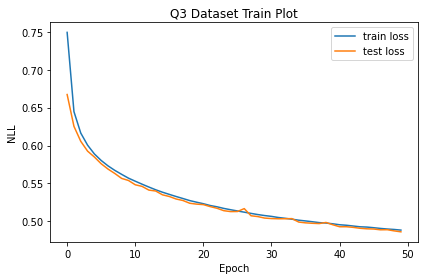

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


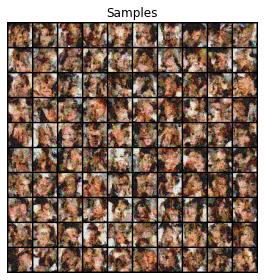

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


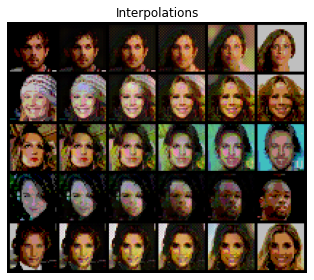

CPU times: user 1.06 s, sys: 485 ms, total: 1.54 s
Wall time: 1.25 s


In [ ]:
%%time

q3_save_results(q3_a, 'a')

## Part (b): Exploring bad masking schemes [10pt]

As shown in lecture, the choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

In [ ]:
class AffineHalfHalfTransform(nn.Module):
    def __init__(self, input_shape, mask_type):
        super().__init__()
        assert mask_type in ("top", "bottom", "left", "right")
        self.input_shape = input_shape
        self.create_mask(mask_type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResNet(input_shape[0], input_shape[0] * 2, 64, 4)
    
    def create_mask(self, mask_type):
        self.register_buffer("mask", torch.zeros(1, 1, self.input_shape[-2], self.input_shape[-1]))
        if mask_type == "top":
            self.mask[:, :, :self.input_shape[-2] // 2, :] = 1
        elif mask_type == "bottom":
            self.mask[:, :, self.input_shape[-2] // 2:, :] = 1
        elif mask_type == "left":
            self.mask[:, :, :, :self.input_shape[-1] // 2] = 1
        elif mask_type == "right":
            self.mask[:, :, :, self.input_shape[-1] // 2:] = 1
        else:
            raise NotImplementedError

    def forward(self, x, reverse=False):
        x_ = x * self.mask
        log_s, t = self.resnet(x_).chunk(2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - self.mask)
        log_s = log_s * (1.0 - self.mask)

        if reverse:
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

class BadRealNVP(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.prior = normal_init(0.0, 1.0)
        self.transforms = nn.ModuleList([
            AffineHalfHalfTransform(input_shape, "top"),
            ActNorm(input_shape[0]),
            AffineHalfHalfTransform(input_shape, "bottom"),
            ActNorm(input_shape[0]),
            AffineHalfHalfTransform(input_shape, "left"),
            ActNorm(input_shape[0]),
            AffineHalfHalfTransform(input_shape, "right"),
            ActNorm(input_shape[0]),
            AffineHalfHalfTransform(input_shape, "top"),
            ActNorm(input_shape[0]),
            AffineHalfHalfTransform(input_shape, "bottom"),
            ActNorm(input_shape[0]),
            AffineHalfHalfTransform(input_shape, "left"),
            ActNorm(input_shape[0]),
            AffineHalfHalfTransform(input_shape, "right"),
        ])

    def f(self, x):
        # x -> z, log_det
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op(z)
            log_det += delta_log_det
        return z, log_det
    
    def g(self, z):
        # z -> x
        x = z
        for op in reversed(self.transforms):
            x, _ = op(x, reverse=True)
        return x

    def log_prob(self, x):
        z, log_det = self.f(x)
        return log_det.sum(dim=(1, 2, 3)) + self.prior.log_prob(z).sum(dim=(1, 2, 3))

    def sample(self, n):
        z = self.prior.sample((n, ) + tuple(self.input_shape))
        return self.g(z)

class BadSolver(Solver):
    def __init__(self, lr=5e-4, n_epochs=0):
        super(BadSolver, self).__init__(lr, n_epochs)

    def build(self):
        self.flow = BadRealNVP(self.input_shape).to(device)
        self.optimizer = optim.Adam(self.flow.parameters(), lr=self.lr)

In [ ]:
solver = BadSolver(n_epochs=50)
solver.build()
solver.train(model_name="badrealnvp")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Calc done | It took 10.20 s | Loss: 1.0917
Epoch 1, train loss 1.1671, test loss 1.0917, time elapsed 1.791 min


Calc done | It took 10.19 s | Loss: 1.0543
Epoch 2, train loss 1.0717, test loss 1.0543, time elapsed 3.582 min


Calc done | It took 10.19 s | Loss: 1.0330
Epoch 3, train loss 1.0437, test loss 1.0330, time elapsed 5.369 min


Calc done | It took 10.20 s | Loss: 1.0154
Epoch 4, train loss 1.0238, test loss 1.0154, time elapsed 7.159 min


Calc done | It took 10.20 s | Loss: 1.0059
Epoch 5, train loss 1.0113, test loss 1.0059, time elapsed 8.947 min


Calc done | It took 10.20 s | Loss: 0.9985
Epoch 6, train loss 1.0028, test loss 0.9985, time elapsed 10.735 min


Calc done | It took 10.18 s | Loss: 0.9921
Epoch 7, train loss 0.9966, test loss 0.9921, time elapsed 12.521 min


Calc done | It took 10.19 s | Loss: 0.9872
Epoch 8, train loss 0.9909, test loss 0.9872, time elapsed 14.308 min


Calc done | It took 10.20 s | Loss: 0.9856
Epoch 9, train loss 0.9868, test loss 0.9856, time elapsed 16.096 min


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BadRealNVP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AffineHalfHalfTransform. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type SimpleResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type WeightNormConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be check

Calc done | It took 10.18 s | Loss: 0.9813
Epoch 10, train loss 0.9831, test loss 0.9813, time elapsed 17.882 min


Calc done | It took 10.19 s | Loss: 0.9795
Epoch 11, train loss 0.9802, test loss 0.9795, time elapsed 19.669 min


Calc done | It took 10.19 s | Loss: 0.9757
Epoch 12, train loss 0.9771, test loss 0.9757, time elapsed 21.453 min


Calc done | It took 10.18 s | Loss: 0.9761
Epoch 13, train loss 0.9745, test loss 0.9761, time elapsed 23.238 min


Calc done | It took 10.18 s | Loss: 0.9707
Epoch 14, train loss 0.9724, test loss 0.9707, time elapsed 25.022 min


Calc done | It took 10.18 s | Loss: 0.9693
Epoch 15, train loss 0.9703, test loss 0.9693, time elapsed 26.805 min


Calc done | It took 10.18 s | Loss: 0.9676
Epoch 16, train loss 0.9682, test loss 0.9676, time elapsed 28.586 min


Calc done | It took 10.18 s | Loss: 0.9657
Epoch 17, train loss 0.9668, test loss 0.9657, time elapsed 30.368 min


Calc done | It took 10.18 s | Loss: 0.9647
Epoch 18, train loss 0.9651, test loss 0.9647, time elapsed 32.153 min


Calc done | It took 10.18 s | Loss: 0.9654
Epoch 19, train loss 0.9636, test loss 0.9654, time elapsed 33.935 min


Calc done | It took 10.18 s | Loss: 0.9624
Epoch 20, train loss 0.9625, test loss 0.9624, time elapsed 35.717 min


Calc done | It took 10.18 s | Loss: 0.9593
Epoch 21, train loss 0.9614, test loss 0.9593, time elapsed 37.503 min


Calc done | It took 10.18 s | Loss: 0.9594
Epoch 22, train loss 0.9597, test loss 0.9594, time elapsed 39.285 min


Calc done | It took 10.18 s | Loss: 0.9576
Epoch 23, train loss 0.9589, test loss 0.9576, time elapsed 41.067 min


Calc done | It took 10.18 s | Loss: 0.9581
Epoch 24, train loss 0.9576, test loss 0.9581, time elapsed 42.850 min


Calc done | It took 10.22 s | Loss: 0.9569
Epoch 25, train loss 0.9564, test loss 0.9569, time elapsed 44.634 min


Calc done | It took 10.19 s | Loss: 0.9565
Epoch 26, train loss 0.9557, test loss 0.9565, time elapsed 46.423 min


Calc done | It took 10.18 s | Loss: 0.9557
Epoch 27, train loss 0.9547, test loss 0.9557, time elapsed 48.209 min


Calc done | It took 10.18 s | Loss: 0.9526
Epoch 28, train loss 0.9538, test loss 0.9526, time elapsed 49.994 min


Calc done | It took 10.18 s | Loss: 0.9523
Epoch 29, train loss 0.9530, test loss 0.9523, time elapsed 51.779 min


Calc done | It took 10.19 s | Loss: 0.9516
Epoch 30, train loss 0.9522, test loss 0.9516, time elapsed 53.568 min


Calc done | It took 10.19 s | Loss: 0.9503
Epoch 31, train loss 0.9513, test loss 0.9503, time elapsed 55.352 min


Calc done | It took 10.19 s | Loss: 0.9526
Epoch 32, train loss 0.9506, test loss 0.9526, time elapsed 57.138 min


Calc done | It took 10.19 s | Loss: 0.9502
Epoch 33, train loss 0.9498, test loss 0.9502, time elapsed 58.925 min


Calc done | It took 10.19 s | Loss: 0.9494
Epoch 34, train loss 0.9490, test loss 0.9494, time elapsed 60.710 min


Calc done | It took 10.19 s | Loss: 0.9488
Epoch 35, train loss 0.9485, test loss 0.9488, time elapsed 62.494 min


Calc done | It took 10.18 s | Loss: 0.9466
Epoch 36, train loss 0.9479, test loss 0.9466, time elapsed 64.279 min


Calc done | It took 10.19 s | Loss: 0.9486
Epoch 37, train loss 0.9471, test loss 0.9486, time elapsed 66.064 min


Calc done | It took 10.19 s | Loss: 0.9458
Epoch 38, train loss 0.9463, test loss 0.9458, time elapsed 67.848 min


Calc done | It took 10.19 s | Loss: 0.9455
Epoch 39, train loss 0.9456, test loss 0.9455, time elapsed 69.633 min


Calc done | It took 10.19 s | Loss: 0.9451
Epoch 40, train loss 0.9454, test loss 0.9451, time elapsed 71.420 min


Calc done | It took 10.18 s | Loss: 0.9448
Epoch 41, train loss 0.9445, test loss 0.9448, time elapsed 73.206 min


Calc done | It took 10.20 s | Loss: 0.9442
Epoch 42, train loss 0.9438, test loss 0.9442, time elapsed 74.991 min


Calc done | It took 10.19 s | Loss: 0.9442
Epoch 43, train loss 0.9446, test loss 0.9442, time elapsed 76.777 min


Calc done | It took 10.19 s | Loss: 0.9440
Epoch 44, train loss 0.9431, test loss 0.9440, time elapsed 78.563 min


Calc done | It took 10.19 s | Loss: 0.9415
Epoch 45, train loss 0.9428, test loss 0.9415, time elapsed 80.350 min


Calc done | It took 10.19 s | Loss: 0.9408
Epoch 46, train loss 0.9418, test loss 0.9408, time elapsed 82.136 min


Calc done | It took 10.19 s | Loss: 0.9409
Epoch 47, train loss 0.9415, test loss 0.9409, time elapsed 83.923 min


Calc done | It took 10.18 s | Loss: 0.9414
Epoch 48, train loss 0.9409, test loss 0.9414, time elapsed 85.708 min


Calc done | It took 10.18 s | Loss: 0.9398
Epoch 49, train loss 0.9404, test loss 0.9398, time elapsed 87.491 min


Calc done | It took 10.19 s | Loss: 0.9408
Epoch 50, train loss 0.9400, test loss 0.9408, time elapsed 89.277 min


([1.1671215444327163,
  1.0716597104605776,
  1.04368094285837,
  1.0238304168652421,
  1.0113183393265113,
  1.0027657503518053,
  0.9965805179013992,
  0.9909086046508326,
  0.9867654328529065,
  0.9830956278136744,
  0.9801502140185323,
  0.9770760741858436,
  0.9744836762309456,
  0.9724464957325604,
  0.9702764852359272,
  0.9682490848504697,
  0.9668022443692144,
  0.9651365731470882,
  0.9636495109564199,
  0.9625404037225741,
  0.9613600816970436,
  0.9597489264445563,
  0.9589362750038172,
  0.9575538124901037,
  0.9563917136801698,
  0.9556890529946397,
  0.9546797917292903,
  0.9537932352897839,
  0.9530035563932059,
  0.9522394250376156,
  0.951258865027382,
  0.950624066800736,
  0.9497731889779575,
  0.9489581847724061,
  0.9484891727709541,
  0.9479288399790804,
  0.9470962017488936,
  0.9463369981549419,
  0.9456443746630757,
  0.9454415099689374,
  0.9444701587811065,
  0.9437525860798626,
  0.944609526056832,
  0.9431255972042633,
  0.942750600199349,
  0.941774878448

In [ ]:
def q3_b(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
    - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
    """
    
    """ YOUR CODE HERE """
    solver = BadSolver()
    solver.build()
    solver.load_model("badrealnvp_final.model")
    train_losses = np.load("badrealnvp_train_losses.npy")
    test_losses = np.load("badrealnvp_test_losses.npy")
    samples = np.transpose(solver.sample(100), axes=(0, 2, 3, 1))
    interpolations = np.transpose(solver.interpolate(), axes=(0, 2, 3, 1))
    return train_losses, test_losses, samples, interpolations

Final Test Loss: 0.9408


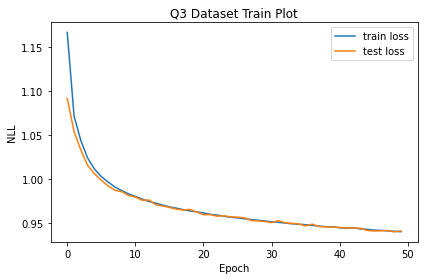

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


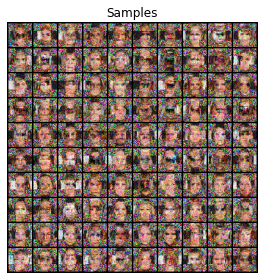

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


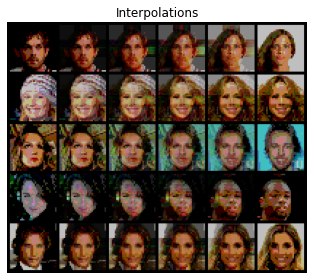

CPU times: user 1.13 s, sys: 407 ms, total: 1.53 s
Wall time: 1.22 s


In [ ]:
%%time

q3_save_results(q3_b, 'b')

# Question 4: Bonus Questions (Optional)

## Q4(a): Multiscale RealNVP [10pt]
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_a, 'bonus_a')

## Q4(b): Glow [5pt]
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_b, 'bonus_b')

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)